<a href="https://colab.research.google.com/github/nicholashagemann/lambdalectures/blob/main/DS29_GP_Unit2_Sprint2_Module3_Nivi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OVERVIEW** 
1. Announcements
2. Redo basics of Tree vs RF
3. Cross validation
4. Grid Search
5. Randomized search
6. Working locally.
7. Date stamp for submissions
8. Visualization

# Cross-Validation

- Do **k-fold cross-validation** with independent test set
- Use scikit-learn for **hyperparameter optimization**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!pip install category_encoders==2.*

     |████████████████████████████████| 81kB 5.4MB/s 


In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Wrangle Data

In [ ]:

train = pd.merge(
    pd.read_csv('/content/gdrive/My Drive/Kaggle/train_features.csv', na_values=[0, -2.000000e-08], parse_dates=['date_recorded']), 
    pd.read_csv('train_labels.csv', na_values=[0, -2.000000e-08])
    )

def wrangle(df):

  # Set the index to 'id'
  df.set_index('id', inplace=True)

  # Drop Constant Column
  df.drop(columns='recorded_by', inplace=True)

  # Drop Duplicate Column
  df.drop(columns='quantity_group', inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop High Cardinality Columns
  cols_to_drop = [col for col in df.select_dtypes('object') if df[col].nunique() > 100]
  df.drop(columns=cols_to_drop, inplace=True)

  # Drop columns with high proportion of null values
  df.drop(columns='num_private', inplace=True)

  return df

train = wrangle(train)



# II. Split Data

## Split TV from FM

In [ ]:
target = 'status_group'
y = train[target]
X = train.drop(columns=target)

# **METHOD 1**

# 1.1 TRAIN AND VALIDATION SPLIT

In [ ]:
# REgular 80-20 training - validation split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

# 1.2 ESTABLISH BASELINE

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.542609255977723


# 1.3 BUILD DT AND RF MODELS


In [ ]:
model_dt=make_pipeline(OrdinalEncoder(),
                       SimpleImputer(),
                       DecisionTreeClassifier(random_state=42))
model_dt.fit(X_train,y_train)

In [ ]:
model_rf=make_pipeline(OrdinalEncoder(),
                       SimpleImputer(),
                       RandomForestClassifier(n_estimators =50, random_state=42))
model_rf.fit(X_train,y_train)

# 1.4 ACCURACIES FOR THE MODELS


In [ ]:
print('TREE: Training accuracy:', model_dt.score(X_train,y_train))
print('TREE: Validation accuracy:', model_dt.score(X_val,y_val))

TREE: Training accuracy: 0.99536850583971
TREE: Validation accuracy: 0.7439880335979749


In [ ]:
print('RF: Training accuracy:', model_rf.score(X_train,y_train))
print('RF: Validation accuracy:', model_rf.score(X_val,y_val))

RF: Training accuracy: 0.9947931649502331
RF: Validation accuracy: 0.7902427798872397


# **METHOD 2**

# 2.1 Training-Validation Split

- Since we're doing k-fold CV, there's no need for a validation set. We can go ahead and use method_dt and method_rf since they are just pipelines.

- We are also not tuning any parameters here. This is just to demonstrate 5 fold CV.


**Check cross-validation scores**

![Cross Validation](https://upload.wikimedia.org/wikipedia/commons/4/4b/KfoldCV.gif)

In [ ]:
cv_scores_dt = cross_val_score(model_dt, X, y, cv=5, n_jobs=-1)
cv_scores_rf = cross_val_score(model_rf, X, y, cv=5, n_jobs=-1)

# 2.2 Train_Test_Split scores (can't be compared to CV scores)
We take the mean accuracy for both models.


In [ ]:
print('CV score DecisionTreeClassifier')
print(cv_scores_dt)
print('Mean CV accuracy score:', cv_scores_dt.mean())
print('STD CV accuracy score:', cv_scores_dt.std())

CV score DecisionTreeClassifier
[0.75100679 0.74905074 0.7500863  0.75270426 0.74810127]
Mean CV accuracy score: 0.7501898701075501
STD CV accuracy score: 0.0015912327994235477


In [ ]:
print('CV score RandomForest')
print(cv_scores_rf)
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())

CV score RandomForest
[0.79219883 0.79910252 0.79956277 0.79896433 0.79401611]
Mean CV accuracy score: 0.7967689099168631
STD CV accuracy score: 0.003050730774971721


# TUNE HYPERPARAMETERS USING CV

In addition to 5 fold CV, we are also incorporating grid search to choose the optimal parameters

- What are important hyperparameters for `RandomForestClassifier`?
  - `max_depth`: 5-35
  - `n_estimators` 25-100
  - imputation strategy

**`GridSearch`:** Very thourough, but it can take a long time.

Test out every single combination of hyperparameters that we provide it
**and** it's going to use cross-validation.

In [ ]:
clf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

param_grid = {
    'simpleimputer__strategy':['mean','median'],
    'randomforestclassifier__max_depth': range(5,35,5),
    'randomforestclassifier__n_estimators': range(25,125,25)

}

model_rfgs = GridSearchCV(
    clf,
    param_grid = param_grid,
    n_jobs = -1,
    cv = 5,
    verbose = 1
)
model_rfgs.fit(X,y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 10.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=None,
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                                       handle_unknown='value',
                                                       mapping=None,
                                                       return_df=True,
                                                       verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
          

In [ ]:
model_rfrs.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__n_estimators': 75,
 'simpleimputer__strategy': 'mean'}

In [ ]:
print('The best accuracy score for the grid search is: ', model_rfgs.best_score_)

The best accuracy score for the grid search is:  0.8053299082327803


**`RandomizedSearchCV`:** Quicker, less effective but usually good enough.

In [ ]:
model_rfrs = RandomizedSearchCV(
    clf,
    param_distributions = param_grid,
    n_iter = 20,
    cv = 5,
    n_jobs = -1,
    verbose = 1
)
model_rfrs.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [ ]:
model_rfrs.best_estimator_.named_steps['simpleimputer']

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [ ]:
model_rfrs.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__n_estimators': 75,
 'simpleimputer__strategy': 'mean'}

In [ ]:
# Uses the best model to retrain and score your test data
model_rfrs.best_estimator_(X_test)

In [ ]:
print('The best accuracy score for the grid search is: ', model_rfrs.best_score_)

The best accuracy score for the grid search is:  0.8046855793971754


## You can see that the GridSearch and RandomSearch gave similar results. So it is a good tradeoff to do a RandomSearch to reduce computation.

# Make Submission

In [ ]:
#y_pred = model_rfrs.predict(X_test)
#submission = pd.DataFrame({'status_group':y_pred}, index=X_test.index)
datestamp = pd.Timestamp.now().strftime('%Y-%m-%d_%H%M_')
submission.to_csv(f'{datestamp}submission.csv')

# VI. Communicate Results

**Showing Feature Importance**

Plot the feature importance for our `RandomForest` model.

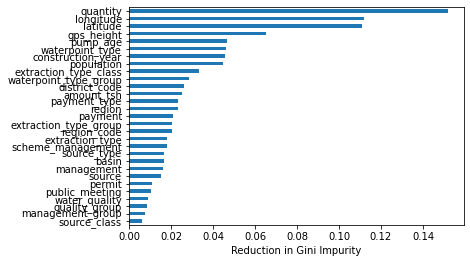

In [ ]:
bestimator = model_rfrs.best_estimator_
importances = bestimator.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');

In [ ]:
#save model
import pickle
filename = 'accuracy_80perc'
pickle.dump(model_dt,open(filename,'wb'))

#load model
model_dt = pickle.load(open(filename,'rb'))
